In [1]:
from geopy import distance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from numpy import genfromtxt

# load the names of cities
city_names = pd.read_csv('../datasets/bc_city_name.csv', names=['city'])['city'].tolist()

### Christofides algorithm

In [2]:
def chriSerd(A):
    """ Christofides–Serdyukov algorithm to compute approximate solution to a TSP problem
        Input: Weighted adjacency matrix. 
        Output: List of vertices of an approximate optimal TSP tour,
                min spanning tree, 
                perfect mathicng"""
    Aoriginal = A.copy()
    # init a graph with 'inverted weights'
    _A = 2*np.max(A)-np.matrix(A)
    np.fill_diagonal(_A,0)
    G = nx.from_numpy_matrix(_A)
    # get minimum spanning tree
    mst = nx.MultiGraph(nx.maximum_spanning_tree(G))
    mstcopy = mst.copy()    
    # get all the odd degree nodes in min span tree
    odd_nodes = []
    for v in mst.degree:
        if v[1] % 2 == 1:
            odd_nodes.append(v[0])

    # get a subgraph from the odd nodes
    subG = nx.subgraph(G, odd_nodes)
    # get min weight matching. Since weights are inverted this is min_weight_matching
    M = nx.algorithms.max_weight_matching(subG)
    # add edges to a spaning tree
    mathching_edges = []
    for u,v in M:
        mathching_edges.append((u,v,1))
    mst.add_edges_from(mathching_edges)
    # get eulerian circuit
    euler_circ = list(nx.eulerian_circuit(mst))
    opt_tour = []
    opt_cost = np.Inf
    
    # do shortcutting in both directions of the Euler circuit
    # this helps to find minimal short-cutting
    for i in [0,1]:
        if i==1: 
            euler_circ.reverse()
            euler_circ = [(uv[1], uv[0]) for uv in euler_circ]
        visited = []
        tour = []

        for uv in euler_circ:
            if uv[0] not in visited:
                tour.append(uv[0])
                visited.append(uv[0])
        tour.append(visited[0])

        # compute the cost 
        _, tour_matrix = buildTourGraph(tour)
        tour_cost = np.sum(np.multiply(tour_matrix, Aoriginal))
        print(tour_cost)
        if tour_cost <= opt_cost:
            opt_cost = tour_cost
            opt_tour = tour
            
    print('Christofides. ','cost: ',opt_cost, ', optimal tour:', opt_tour)
    return np.array(opt_tour), mstcopy, M


### Duoble spanning tree algorithm

In [3]:
def doubleSpanTree(A):
    """ Double Spaning Tree algorithm to compute approximate solution to a TSP problem
    Input: Weighted adjacency matrix. 
    Output: List of vertices of an approximate optimal TSP tour """
    # init a graph with 'inverted weights'
    G = nx.from_numpy_matrix(np.max(A)-np.matrix(A))
    # get minimum spanning tree
    mst = nx.MultiGraph(nx.maximum_spanning_tree(G))
    mstcopy = mst.copy()

    # add double edges
    double_edges = []
    for u,v,k in mst.edges:
        double_edges.append((u,v,1))
    mst.add_edges_from(double_edges)
    # do Euler Circuit
    euler_circ = list(nx.eulerian_circuit(mst))
    euler_circ.reverse()
    # do shortcutting
    visited = [euler_circ[0][0]]
    opt_tour = [euler_circ[0][0]]
    for uv in euler_circ[1:]:
        if uv[0] not in visited:
            opt_tour.append(uv[0])
            visited.append(uv[0])
    opt_tour.append(visited[0])
    print('Double Min Span Tree optimal tour:', opt_tour)
    
    return np.array(opt_tour), mstcopy

### Some helper functions


In [4]:
def buildTourGraph(opt_tour):
    """ Build a graph from the provided list of nodes.
        Input:
            graph_size: size of a matrix for a graph
            opt_tour: list of vertices on a tour
        Output: A nx.Graph object and 0,1 adjacency matrix
        """
    n = len(opt_tour)-1
    opt_tour_matrix = np.zeros((n,n))

    for i in range(0, len(opt_tour)-1):
        u = opt_tour[i]
        v = opt_tour[i+1]
        opt_tour_matrix[u,v] = 1

    opt_tour_G = nx.Graph(opt_tour_matrix)
    return opt_tour_G, opt_tour_matrix

### Load the dataset and find approx optimal tours using Christofides and NN algos.

In [5]:
points = np.genfromtxt('../datasets/bc100_xy.csv', delimiter=',')

# compute the cost matrix
n = len(points)
A = np.zeros((n,n))
for i in range(0, n):
    for j in range(0, n):
        a = np.matrix(points[i])
        b = np.matrix(points[j])
        A[i][j] = np.linalg.norm(a-b)

np.savetxt('../datasets/bc_distance_matrix.csv', A)

# Get tours from christofides and dMST
chris_tour, chris_mst, matching = chriSerd(A)
dmst_tour, dmst_mst = doubleSpanTree(A)


    
# load NN and NI tours from csv
nn_tour = np.genfromtxt('NN-and-NI/100city_neighbour.csv', delimiter=',', dtype=int)-1
ni_tour = np.genfromtxt('NN-and-NI/100city_insertion.csv', delimiter=',',dtype=int)-1


4709.576629488225
4723.390971188596
Christofides.  cost:  4709.576629488225 , optimal tour: [0, 4, 10, 3, 13, 22, 99, 49, 32, 86, 77, 57, 12, 91, 29, 44, 76, 39, 24, 55, 38, 2, 35, 9, 40, 52, 50, 21, 60, 95, 47, 97, 59, 37, 82, 30, 43, 42, 25, 80, 48, 61, 41, 70, 93, 78, 84, 98, 31, 45, 17, 58, 53, 11, 65, 36, 94, 75, 72, 20, 56, 51, 68, 88, 28, 5, 92, 46, 89, 85, 90, 64, 33, 81, 71, 69, 54, 62, 87, 63, 83, 79, 73, 74, 26, 96, 66, 67, 14, 23, 6, 8, 15, 16, 34, 19, 27, 7, 1, 18, 0]
Double Min Span Tree optimal tour: [3, 18, 1, 19, 7, 27, 34, 16, 8, 15, 23, 6, 14, 67, 66, 96, 51, 26, 74, 73, 79, 83, 63, 87, 62, 54, 69, 33, 64, 90, 85, 71, 81, 68, 88, 28, 5, 92, 46, 56, 20, 72, 75, 94, 36, 11, 65, 53, 58, 17, 78, 84, 98, 31, 45, 93, 70, 41, 61, 48, 89, 13, 22, 86, 77, 57, 12, 95, 60, 29, 21, 50, 52, 40, 9, 55, 24, 39, 76, 44, 38, 2, 35, 91, 47, 97, 59, 37, 82, 30, 25, 80, 42, 43, 32, 49, 99, 0, 4, 10, 3]


### 2-opt heuristic
base algorithm credit to Fredge at Applications Engineer at Immense Simulations

In [6]:
def cost_change(cost_mat, n1, n2, n3, n4):
    return cost_mat[n1][n3] + cost_mat[n2][n4] - cost_mat[n1][n2] - cost_mat[n3][n4]

def print_switch(route, node_names, cost_mat, n1, n2, n3, n4):
    n1 = route[n1]
    n2 = route[n2]
    n3 = route[n3]
    n4 = route[n4]
    print(f'\t Cities: {node_names[n1]}, {node_names[n2]}, {node_names[n3]}, {node_names[n4]}')
    print(f'\t Two edge cost before 2-opt switch:', cost_mat[n1][n2] + cost_mat[n3][n4])
    print(f'\t Add edge ({node_names[n1]}, {node_names[n3]})')
    print(f'\t Add edge ({node_names[n2]}, {node_names[n4]})')
    print(f'\t Remove edge ({node_names[n1]}, {node_names[n2]})')
    print(f'\t Remove edge ({node_names[n3]}, {node_names[n4]})')
    print(f'\t Two edge cost after 2-opt switch:', cost_mat[n1][n3] + cost_mat[n2][n4])

def two_opt(route, cost_mat, node_names):
    route = route.copy()
    best = route
    improved = True
    k = 1 # count intersecting edges
    
    while improved:
        improved = False
        
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue
                if cost_change(cost_mat, best[i - 1], best[i], best[j - 1], best[j]) < 0:
                    
                    print(f'Intersection {k}')
                    print_switch(best, node_names, cost_mat, i - 1, i, j-1, j)
                    k += 1
                    
                    best[i:j] = best[j - 1:i - 1:-1]
                    improved = True
        route = best
    return best

### christofides tour 2-opt pass

In [7]:
# build a chris tour adj matrix
chrisGraph, chris_tourMatrix = buildTourGraph(chris_tour)
# compute the cost of the tour
chrisCost  = np.sum(np.multiply(chris_tourMatrix, A))

# do 2-opt pass
chris_two_opt_tour = two_opt(chris_tour, A, city_names)
two_opt_chrisGraph, chris_two_opt_tourMatrix = buildTourGraph(chris_two_opt_tour)

two_opt_chrisCost  = np.sum(np.multiply(chris_two_opt_tourMatrix, A))
print('chris cost', chrisCost)
print('2-opt chris cost', two_opt_chrisCost)
print('Chris original tour:', chris_tour)
print('Christ 2-opt tour:', chris_two_opt_tour)


Intersection 1
	 Cities: Vancouver, Richmond, New Westminster, Vancouver
	 Two edge cost before 2-opt switch: 23.63145675883449
	 Add edge (Vancouver, New Westminster)
	 Add edge (Richmond, Vancouver)
	 Remove edge (Vancouver, Richmond)
	 Remove edge (New Westminster, Vancouver)
	 Two edge cost after 2-opt switch: 23.63145675883449
Intersection 2
	 Cities: Surrey, Coquitlam, Port Moody, Port Coquitlam
	 Two edge cost before 2-opt switch: 15.39384439177497
	 Add edge (Surrey, Port Moody)
	 Add edge (Coquitlam, Port Coquitlam)
	 Remove edge (Surrey, Coquitlam)
	 Remove edge (Port Moody, Port Coquitlam)
	 Two edge cost after 2-opt switch: 12.910135446100293
Intersection 3
	 Cities: Maple Ridge, White Rock, Burnaby, Delta
	 Two edge cost before 2-opt switch: 46.84131642451797
	 Add edge (Maple Ridge, Burnaby)
	 Add edge (White Rock, Delta)
	 Remove edge (Maple Ridge, White Rock)
	 Remove edge (Burnaby, Delta)
	 Two edge cost after 2-opt switch: 45.46233346673745
Intersection 4
	 Cities: Se

### Create a matrix (dataframe) of weights of the 2-opt tour. From the matrix we can further extract the tour weight table by looking at the non-zero entries

In [8]:
# create a table for the original christ tour
chris_table = pd.DataFrame(np.multiply(chris_tourMatrix, A),
                    columns=city_names,
                    index=city_names)
# create a table for the 2-opt christ tour
chris_2_opt_table = pd.DataFrame(np.multiply(chris_two_opt_tourMatrix, A),
    columns=city_names,
    index=city_names)

chris_2_opt_table.to_csv('../datasets/tour_tables/chris-2opt-and-original.csv')

### NN tour 2-opt pass

In [9]:
# load NN tour
nn_tour = np.genfromtxt('NN-and-NI/100city_neighbour.csv', delimiter=',', dtype=int)-1

# build a chris tour adj matrix
nn_graph, nn_tourMatrix = buildTourGraph(nn_tour)
# compute the cost of the tour
nnCost  = np.sum(np.multiply(nn_tourMatrix, A))

# do 2-opt pass
nn_two_opt_tour = two_opt(nn_tour, A, city_names)
two_opt_nn_Graph, nn_two_opt_tourMatrix = buildTourGraph(nn_two_opt_tour)

two_opt_nn_Cost  = np.sum(np.multiply(nn_two_opt_tourMatrix, A))
print('NN cost', nnCost)
print('2-opt NN cost', two_opt_nn_Cost)
print('NN original tour', nn_tour)
print('NN 2-opt tour:', nn_two_opt_tour)


Intersection 1
	 Cities: Powell River, Comox, Campbell River, Sechelt
	 Two edge cost before 2-opt switch: 152.24233449406702
	 Add edge (Powell River, Campbell River)
	 Add edge (Comox, Sechelt)
	 Remove edge (Powell River, Comox)
	 Remove edge (Campbell River, Sechelt)
	 Two edge cost after 2-opt switch: 137.2400488616353
Intersection 2
	 Cities: Port Hardy, Prince Rupert, Kitimat, Terrace
	 Two edge cost before 2-opt switch: 493.59909431000574
	 Add edge (Port Hardy, Kitimat)
	 Add edge (Prince Rupert, Terrace)
	 Remove edge (Port Hardy, Prince Rupert)
	 Remove edge (Kitimat, Terrace)
	 Two edge cost after 2-opt switch: 488.1082331771248
Intersection 3
	 Cities: Houston, Dawson Creek, Fort St. John, Chetwynd
	 Two edge cost before 2-opt switch: 526.6401725530648
	 Add edge (Houston, Fort St. John)
	 Add edge (Dawson Creek, Chetwynd)
	 Remove edge (Houston, Dawson Creek)
	 Remove edge (Fort St. John, Chetwynd)
	 Two edge cost after 2-opt switch: 523.6445097523201
Intersection 4
	 Cit

### Create a matrix (dataframe) of weights of the 2-opt tour. From the matrix we can further extract the tour weight table by looking at the non-zero entries

In [10]:
# original NN weight table
nn_table = pd.DataFrame(np.multiply(nn_tourMatrix, A),
                            columns=city_names,
                            index=city_names)
# 2-opt table
nn_2_opt_table = pd.DataFrame(np.multiply(nn_two_opt_tourMatrix, A),
                              columns=city_names,
                              index=city_names)
# write table
nn_table.to_csv('../datasets/tour_tables/NN-table.csv')
nn_2_opt_table.to_csv('../datasets/tour_tables/NN-2opt-table.csv')

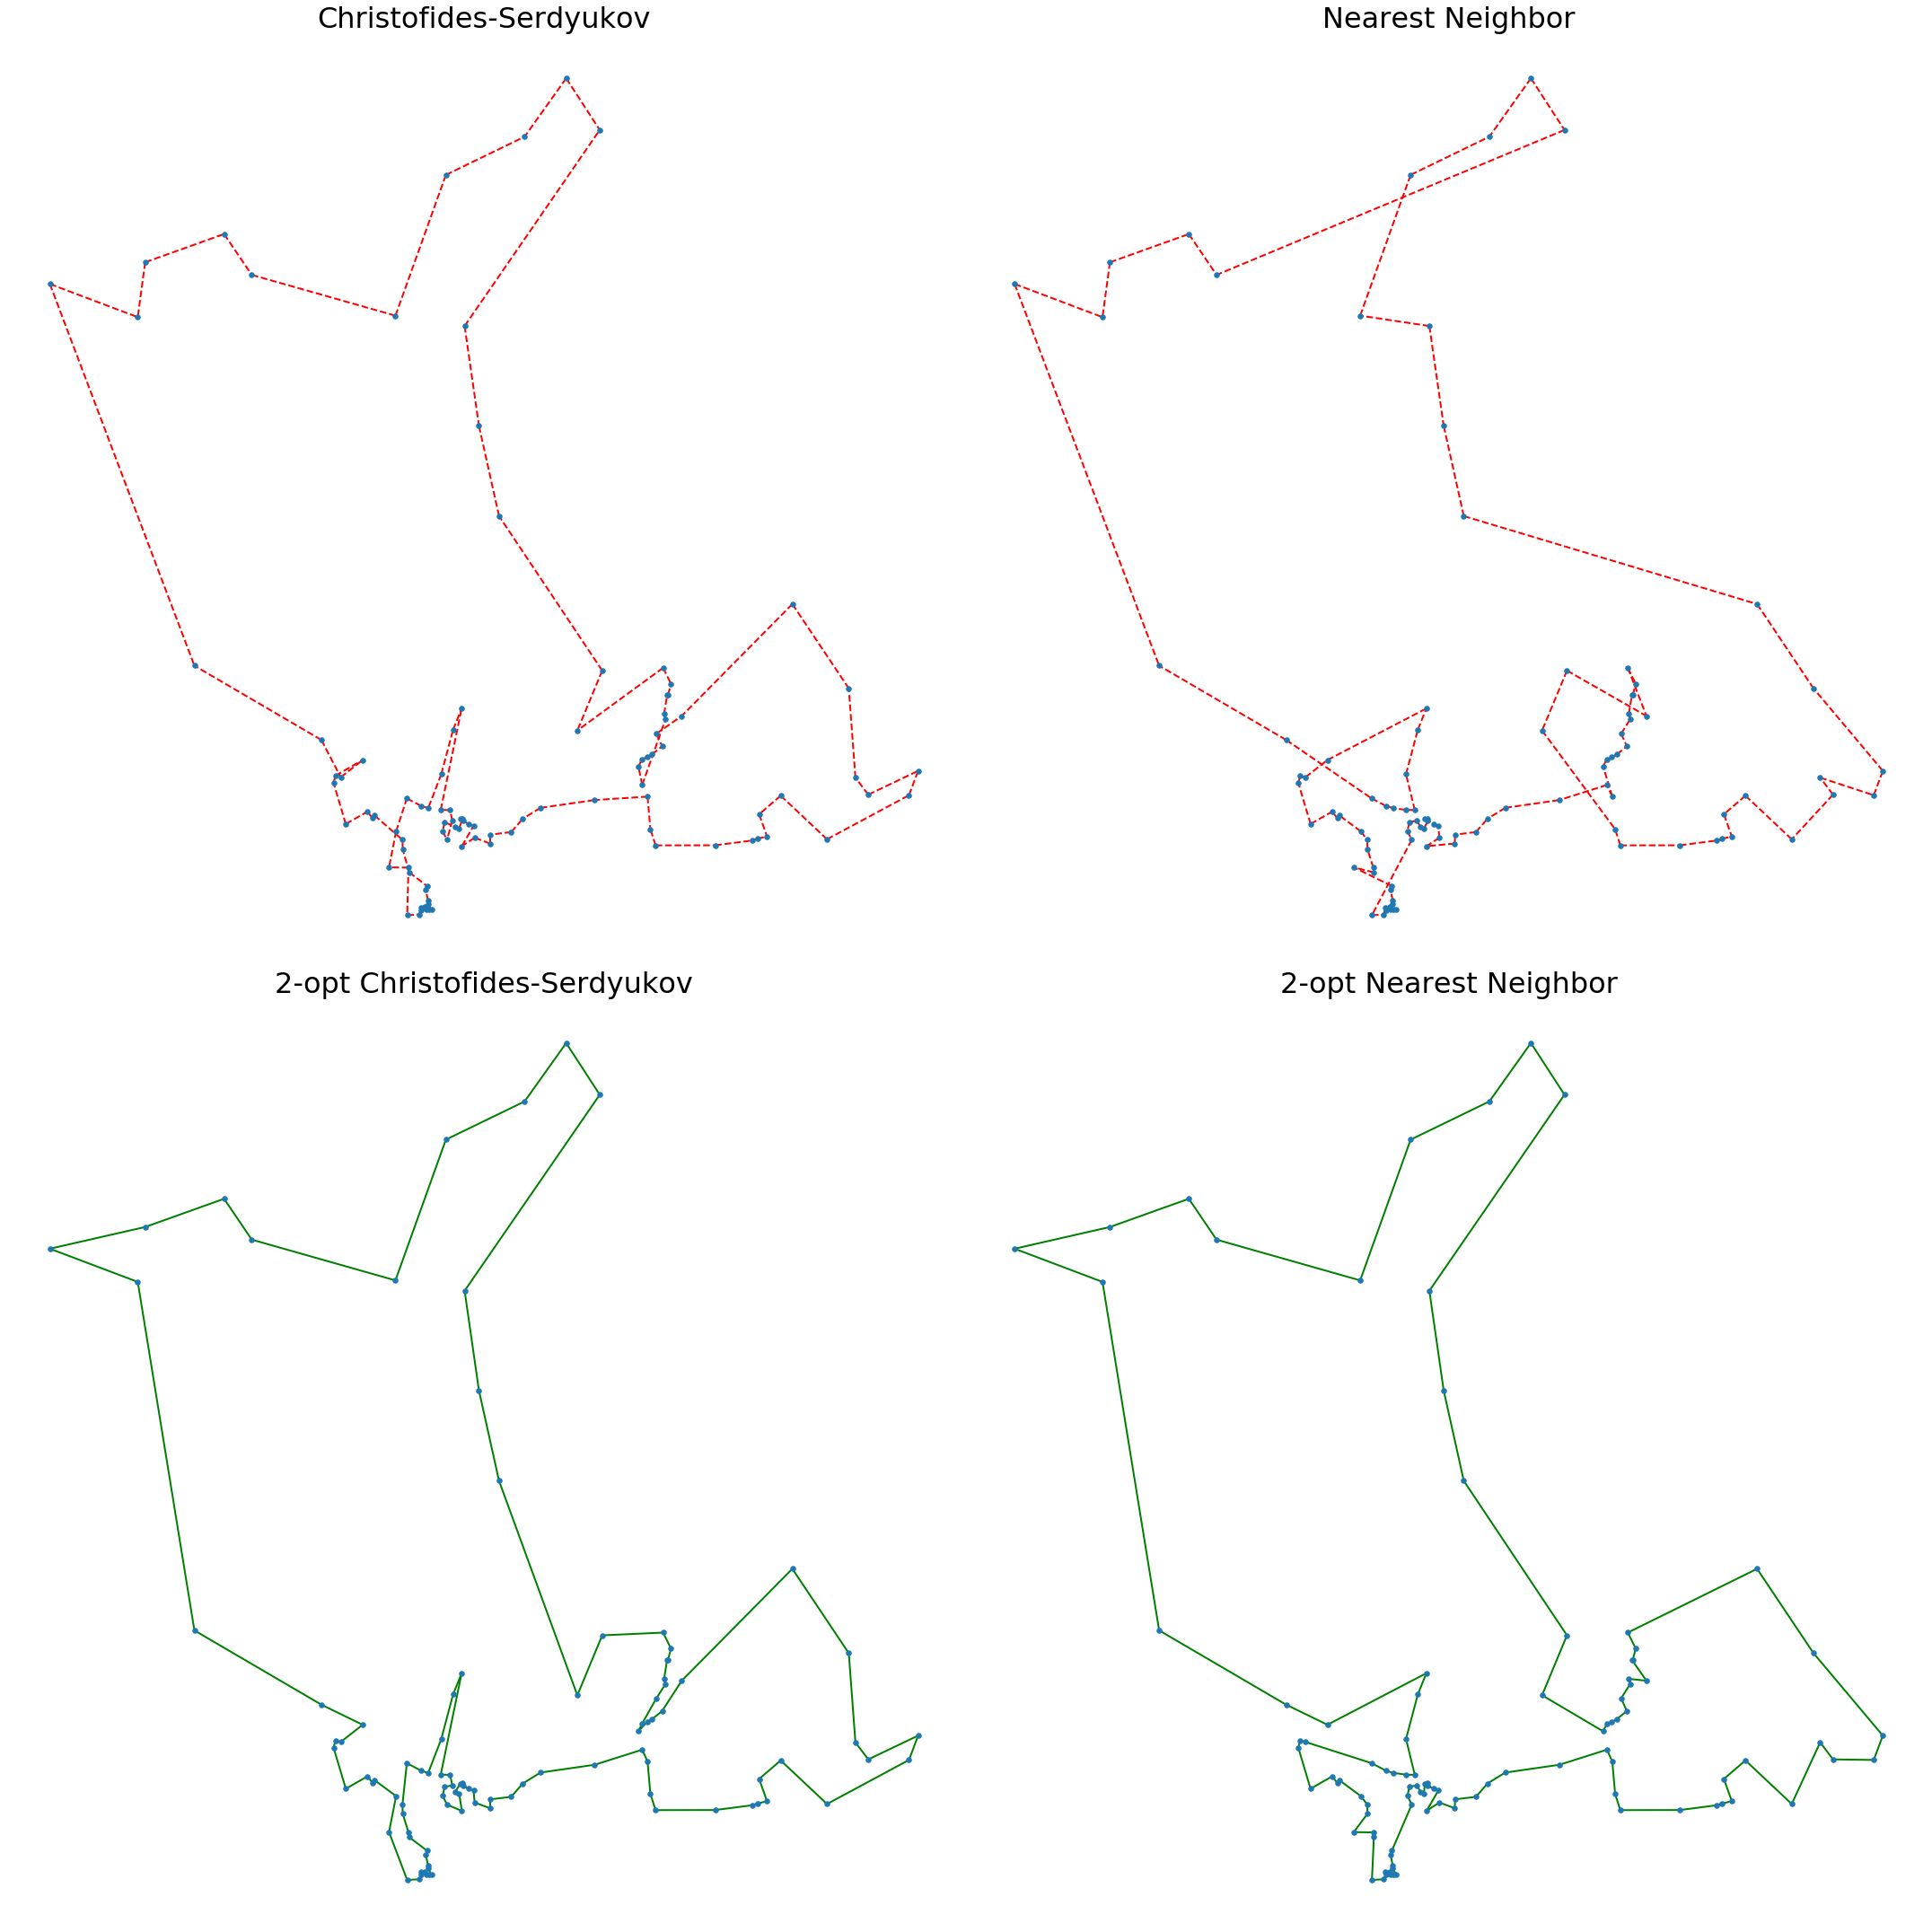

In [27]:

# build the matrix for the optimal tour graph
# opt_tour_G1, opt_tour_matrix1 = buildTourGraph(opt_tour1)
# opt_tour_G2, opt_tour_matrix2 = buildTourGraph(opt_tour2)

G = nx.from_numpy_matrix(np.matrix(A))
G_pos = dict(zip(range(0,n),points))


chris_opt_tour_G, chris_opt_tour_matrix1 = buildTourGraph(chris_tour)
chris_2_opt_tour_G, chris_2_opt_tour_matrix1 = buildTourGraph(chris_two_opt_tour)

nn_opt_tour_G, nn_opt_tour_matrix1 = buildTourGraph(nn_tour)
nn_2_opt_tour_G, nn_2_opt_tour_matrix1 = buildTourGraph(nn_two_opt_tour)

fig, axs = plt.subplots(2, 2, figsize=(30, 30), sharey=True)
axs[0][0].set_title('Christofides-Serdyukov', fontsize=32)
axs[0][1].set_title('Nearest Neighbor', fontsize=32)
axs[1][0].set_title('2-opt Christofides-Serdyukov', fontsize=32)
axs[1][1].set_title('2-opt Nearest Neighbor', fontsize=32)
axs[0][0].axis('off')
axs[0][1].axis('off')
axs[1][0].axis('off')
axs[1][1].axis('off')

nodeSize = 30
edge_width = 2

# Subplot 1 draw G and edge weights
nx.draw_networkx_nodes(G, pos=G_pos,
                        ax=axs[0][0],
                        font_size=30,
                        node_size=nodeSize,
                        with_labels=True,
                        connectionstyle='arc3, rad = 0.3')


# Draw Chris original
nx.draw_networkx_edges(chris_opt_tour_G,
                       pos=G_pos, 
                       connectionstyle='arc3, rad = 0.1',
                       edge_color='r',
                       style='dashed',
                       width=edge_width, ax=axs[0][0])

# Subplot 2 draw G vertices
nx.draw_networkx_nodes(G, pos=G_pos, ax=axs[1][0], font_size=30, node_size=nodeSize)
# Draw 2-opt Chris original
nx.draw_networkx_edges(chris_2_opt_tour_G,
                       pos=G_pos, 
                       connectionstyle='arc3, rad = 0.1',
                       edge_color='g', 
                       width=edge_width, ax=axs[1][0])

# Subplot 3 draw G vertices
nx.draw_networkx_nodes(G, pos=G_pos, ax=axs[0][1], font_size=30, node_size=nodeSize)

# Draw NN original
nx.draw_networkx_edges(nn_opt_tour_G, 
                       pos=G_pos,
                       edge_color='r',
                       style='dashed',
                       width=edge_width,
                       ax=axs[0][1],
                       connectionstyle='arc3, rad = 0.1')


# Subplot 5 draw G vertices
nx.draw_networkx_nodes(G, pos=G_pos, ax=axs[1][1], font_size=30, node_size=nodeSize)
# Draw 2-opt NN 2-opt
nx.draw_networkx_edges(nn_2_opt_tour_G, 
                       pos=G_pos,
                       edge_color='g',
                       width=edge_width,
                       ax=axs[1][1],
                       connectionstyle='arc3, rad = 0.1')

fig.tight_layout()

plt.show()


In [12]:

n = np.shape(A)[0]
opt_tour_G1, opt_tour_matrix1 = buildTourGraph(chris_two_opt_tour)


df = pd.read_csv('../datasets/bc_city_data.csv',delimiter=',',sep='\n' )

CS_title = 'Christofides-Serdyukov approx optimal route'
DMST_tile = 'Double MST optimal route'
NN_title = "Nearest Neighbor optimal route"
NI_title = "Nearest Insertion optimal route"

NN_tour = np.genfromtxt('NN-and-NI/100city_neighbour.csv', delimiter=',', dtype=int)-1
NI_tour = np.genfromtxt('NN-and-NI/100city_insertion.csv', delimiter=',', dtype=int)-1

route_lats_CS = df.iloc[chris_two_opt_tour]['lat']
route_lng_CS = df.iloc[chris_two_opt_tour]['lng']


# route_lats_NI = df.iloc[NI_tour]['lat']
# route_lng_NI = df.iloc[NI_tour]['lng']

route_lats_NN = df.iloc[nn_two_opt_tour]['lat']
route_lng_NN = df.iloc[nn_two_opt_tour]['lng']
